<a href="https://colab.research.google.com/github/amannayak/DeepLearningIntro/blob/master/RNN_Lab_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part-of-Speech Tagging with Recurrent Neural Networks

Your task in this assignment is to implement a simple part-of-speech tagger based on recurrent neural networks.

## Get a graphics card

In [3]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

Using TensorFlow backend.


## Problem specification

Your task in this assignment is

1. to build a part-of-speech tagger based on a recurrent neural network architecture
2. to train this tagger on the provided training data and identify a good model
2. to evaluate the performance of this model on the provided test data

To identify a good model, you can use the provided development (validation) data.

## Part-of-speech tagging

Part-of-speech (POS) tagging is the task of labelling words (tokens) with [parts of speech](https://en.wikipedia.org/wiki/Part_of_speech). To give an example, consider the  sentence *Parker hates parsnips*. In this sentence, the word *Parker* should be labelled as a proper noun (a noun that is the name of a person), *hates* should be labelled as a verb, and *parsnips* should be labelled as a (common) noun. Part-of-speech tagging is an essential ingredient of many state-of-the-art natural language understanding systems.

Part-of-speech tagging can be cast as a supervised machine learning problem where the gold-standard data consists of sentences whose words have been manually annotated with parts of speech. For the present assignment you will be using a corpus built over the source material of the [English Web Treebank](https://catalog.ldc.upenn.edu/ldc2012t13), consisting of approximately 16,000&nbsp;sentences with 254,000&nbsp;tokens. The corpus has been released by the [Universal Dependencies Project](http://universaldependencies.org).

To make it easier to compare systems, the gold-standard data has been split into three parts: training, development (validation), and test. The following cell provides a function that can be used to load the data.

In [0]:
def read_data(path):
    with open(path, encoding='utf-8') as fp:
        result = []
        for line in fp:
            line = line.rstrip()
            if len(line) == 0:
                yield result
                result = []
            elif not line.startswith('#'):
                columns = line.split()
                if columns[0].isdigit():
                    result.append((columns[1], columns[3]))

The next cell loads the data:

In [5]:
train_data = list(read_data('en_ewt-ud-train.conllu'))
print('Number of sentences in the training data: {}'.format(len(train_data)))

dev_data = list(read_data('en_ewt-ud-dev.conllu'))
print('Number of sentences in the development data: {}'.format(len(dev_data)))

test_data = list(read_data('en_ewt-ud-test.conllu'))
print('Number of sentences in the test data: {}'.format(len(test_data)))

Number of sentences in the training data: 9897
Number of sentences in the development data: 2002
Number of sentences in the test data: 2077


From a Python perspective, each of the data sets is a list of what we shall refer to as *tagged sentences*. A tagged sentence, in turn, is a list of pairs $(w,t)$, where $w$ is a word token and $t$ is the word&rsquo;s POS tag. Here is an example from the training data to show you how this looks like:

In [6]:
train_data[42]

[('There', 'PRON'),
 ('has', 'AUX'),
 ('been', 'VERB'),
 ('talk', 'NOUN'),
 ('that', 'SCONJ'),
 ('the', 'DET'),
 ('night', 'NOUN'),
 ('curfew', 'NOUN'),
 ('might', 'AUX'),
 ('be', 'AUX'),
 ('implemented', 'VERB'),
 ('again', 'ADV'),
 ('.', 'PUNCT')]

You will see part-of-speech tags such as `VERB` for verb, `NOUN` for noun, and `ADV` for adverb. If you are interested in learning more about the tag set used in the gold-standard data, you can have a look at the documentation of the [Universal POS tags](http://universaldependencies.org/u/pos/all.html). However, you do not need to understand the meaning of the POS tags to solve this assignment; you can simply treat them as labels drawn from a finite set of alternatives.

## Network architecture

The proposed network architecture for your tagger is a sequential model with three layers, illustrated below: an embedding, a bidirectional LSTM, and a softmax layer. The embedding turns word indexes (integers representing words) into fixed-size dense vectors which are then fed into the bidirectional LSTM. The output of the LSTM at each position of the sentence is passed to a softmax layer which predicts the POS tag for the word at that position.

![architecture.png](attachment:architecture.png)

To implement the network architecture, you will use [Keras](https://keras.io/). Keras comes with an extensive online documentation, and reading the relevant parts of this documentation will be essential when working on this assignment. We suggest to start with the tutorial [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/). After that, you should have a look at some of the examples mentioned in that tutorial, and in particular the [Bidirectional LSTM](https://keras.io/examples/imdb_bidirectional_lstm/) example.

## Evaluation

The most widely-used evaluation measure for part-of-speech tagging is per-word accuracy, which is the percentage of words to which the tagger assigns the correct tag (according to the gold standard). This is one of the default metrics in Keras.

One problem that you will encounter during evaluation is that the evaluation data contains words that you did not see (and did not add to your index) during training. The simplest solution to this problem is to introduce a special &lsquo;word&rsquo; `<unk>` and replace each unknown word with this pseudoword.

## Part 1: Pre-process the data

Before you can start to implement the network architecture as such, you will have to bring the tagged sentences from the gold-standard data into a form that can be used with the network. One important step in this is to map the words and tags (strings) to integers. Here is code that illustrates the idea:

In [6]:
word_to_index = {}
for tagged_sentence in train_data:
    for word, tag in tagged_sentence:
        if word not in word_to_index:
            word_to_index[word] = len(word_to_index)

print('Number of unique words in the training data: {}'.format(len(word_to_index)))
print('Index of the word "hates": {}'.format(word_to_index['hates']))

Number of unique words in the training data: 17231
Index of the word "hates": 4579


Once you have indexes for the words and the tags, you can construct the input and the gold-standard output tensor required to train the network.

### Constructing the input tensor

The input tensor should be of shape $(N, n)$ where $N$ is the total number of sentences in the training data and $n$ is the length of the longest sentence. Note that Keras requires all sequences in an input tensor to have the same length, which means that you will have to pad all sequences to that length. You can use the helper function [`pad_sequences`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) for this, which by default will front-pad sequences with the value&nbsp;0. It is essential then that you do not use this special padding value as the index of actual words.

### Constructing the target output tensor

The target output tensor should be of shape $(N, n, T)$ where $T$ is the number of unique tags in the training data, plus one to cater for the special padding value. The additional dimension corresponds to the fact that the softmax layer of the network will output one $T$-dimensional vector for each position of an input sentence. To construct this vector, you can use the helper function [`to_categorical`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical).

In [11]:
# Define a help function to build index from a list of words or tags, each word / tag will have a unique number
def build_index(strings, init=[]):
    string_to_index = {s: i for i, s in enumerate(init)}
    for word_tag in strings:
      if word_tag not in string_to_index.keys():
        string_to_index[word_tag] = len(string_to_index)
    return string_to_index
        
words, tags = [], []
for tagged_sentence in train_data:
    for word, tag in tagged_sentence:
       words.append(word)
       tags.append(tag)

# Call the help function you made, to build an index for words (word_to_index), and one index for tags (tag_to_index)
word_to_index = build_index(strings = words , init=["<unk>"])
tag_to_index = build_index(strings = tags , init=["<unk>"] )

# Check number of words and tags
num_words = len(word_to_index)
num_tags = len(tag_to_index)

print(f'Number of unique words in the training data: {num_words}')
print(f'Number of unique tags in the training_data: {num_tags}')

Number of unique words in the training data: 17232
Number of unique tags in the training_data: 18


In [0]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Make a function that converts the tagged sentences, word indices and tag indices to 
# X and Y, that can be used when training the RNN
def encode(tagged_sentences, word_to_index, tag_to_index):

    # Start with empty lists that will contain all training examples and corresponding output
    X, Y = [], []
    
    for tagSent in tagged_sentences:        
        Xcurrent, Ycurrent = [], []        

        for currWord , currTag in tagSent:
            #Word
            if word_to_index.get(currWord) is None:
                 Xcurrent.append(word_to_index.get("<unk>"))
            else:
                Xcurrent.append(word_to_index.get(currWord))

            #Tags 
            if tag_to_index.get(currTag) is None:
            #Ycurrent.append("<unk>")
                Ycurrent.append(tag_to_index.get("<unk>"))
            else:
                Ycurrent.append(tag_to_index.get(currTag))
        #End of Inner for loop
        X.append(Xcurrent)
        Y.append(Ycurrent)
    #End of outer for loop    
    X = pad_sequences(X)
    Y = pad_sequences(Y)
    Y = to_categorical(Y , num_classes=len(tag_to_index.keys()) , dtype= 'float32')
    return X, Y

In [16]:

X,Y = encode(train_data, word_to_index, tag_to_index)

# Print the shape of X and Y
print("\n")
print(f"Shape of X is : {X.shape}")
print("\n")
print(f"Shape of Y is : {Y.shape}") 



Shape of X is : (9897, 159)


Shape of Y is : (9897, 159, 18)


In [0]:
#Xval , Yval = encode(dev_data, word_to_index, tag_to_index)

## Part 2: Construct the model

To implement the network architecture, you need to find and instantiate the relevant building blocks from the Keras library. Note that Keras layers support a large number of optional parameters; use the default values unless you have a good reason not to. Two mandatory parameters that you will have to specify are the dimensionality of the embedding and the dimensionality of the output of the LSTM layer. The following values are reasonable starting points, but do try a number of different settings.

* dimensionality of the embedding: 100
* dimensionality of the output of the bidirectional LSTM layer: 100

You will also have to choose an appropriate loss function. For training we recommend the Adam optimiser.

In [22]:
from tensorflow.keras import Sequential
# Import necessary layers
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy 
#from keras.losses import binary_crossentropy 

embedding_dim = 100
hidden_dim = 100
maxFeatures = len(word_to_index.keys())
maxSequence = max(word_to_index.values())

#Model Creation
model = Sequential()

# The model should have an embedding layer, a bidirectional LSTM, and a dense softmax layer 

model.add(Embedding(maxFeatures , embedding_dim))
model.add(Bidirectional(LSTM(hidden_dim , return_sequences=True)))
model.add(Dropout(0.5))



#model.add(Dense(units = len(Y) , activation = 'softmax'))
model.add(Dense(18 , activation = 'softmax'))
# (see the network architecture image)

# Compile model
model.compile(loss = categorical_crossentropy , optimizer = "Adam", metrics=['accuracy'] )
#model.compile(loss = binary_crossentropy , optimizer = "Adam", metrics=['accuracy'] )
# Print a summary of the model
print(model.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1723200   
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 200)         160800    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
dense_2 (Dense)              (None, None, 18)          3618      
Total params: 1,887,618
Trainable params: 1,887,618
Non-trainable params: 0
_________________________________________________________________
None


## Part 3: Train the network

The next step is to train the network. Use the following parameters:

* number of epochs: 10
* batch size: 32

Training will print the average running loss on the training data after each minibatch. In addition to that, we ask you to also print the loss and accuracy on the development data after each epoch. You can do so by providing the `validation_data` argument to the `fit` method.

Note that the `fit` method returns a [`History`](https://keras.io/callbacks/#history) object that contains useful information about the training. We will use that information in the next step.

In [23]:
# Encode the development (validation data) using the 'encode' function you created before
Xval , Yval = encode(dev_data , word_to_index ,  tag_to_index )
# Train the model and save the history, as you did in the DNN and CNN labs, provide validation data
history = model.fit(X, Y , batch_size = 32 , epochs = 10 , verbose = 1 , validation_data = (Xval,Yval))

Epoch 1/10
310/310 [==============================] - 11s 36ms/step - loss: 0.3409 - accuracy: 0.9119 - val_loss: 0.3688 - val_accuracy: 0.8979
Epoch 2/10
310/310 [==============================] - 10s 34ms/step - loss: 0.1182 - accuracy: 0.9658 - val_loss: 0.1293 - val_accuracy: 0.9657
Epoch 3/10
310/310 [==============================] - 10s 34ms/step - loss: 0.0406 - accuracy: 0.9890 - val_loss: 0.1022 - val_accuracy: 0.9739
Epoch 4/10
310/310 [==============================] - 10s 33ms/step - loss: 0.0232 - accuracy: 0.9938 - val_loss: 0.1061 - val_accuracy: 0.9742
Epoch 5/10
310/310 [==============================] - 11s 34ms/step - loss: 0.0170 - accuracy: 0.9953 - val_loss: 0.1080 - val_accuracy: 0.9745
Epoch 6/10
310/310 [==============================] - 10s 33ms/step - loss: 0.0137 - accuracy: 0.9961 - val_loss: 0.1163 - val_accuracy: 0.9730
Epoch 7/10
310/310 [==============================] - 10s 34ms/step - loss: 0.0116 - accuracy: 0.9967 - val_loss: 0.1198 - val_accuracy:

## Part 4: Identify a good model

The following code will plot the loss on the training data and the loss on the validation data after each epoch:

In [0]:
# Lets define a help function for plotting the training results
import matplotlib.pyplot as plt

def plot_results(history):
    
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

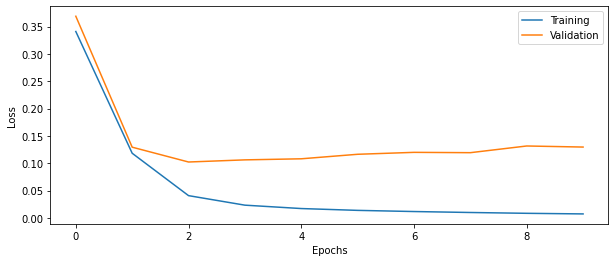

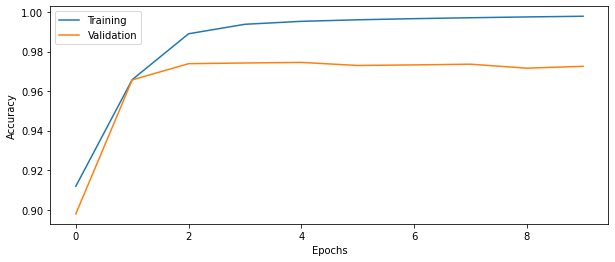

In [25]:
plot_results(history)

Look at the plot and determine the epoch after which the model starts to overfit. Then, re-train your model using that many epochs and compute the accuracy of the tagger on the test data.

In [26]:
# Encode the test_data using the 'encode' function you created before
Xtest , Ytest = encode(test_data , word_to_index ,  tag_to_index )

# Evaluate the model on test data, as you did in the DNN and CNN lab
score = model.evaluate(Xtest , Ytest , verbose = 1)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

65/65 [==============================] - 0s 6ms/step - loss: 0.1219 - accuracy: 0.9752
Test loss: 0.1219
Test accuracy: 0.9752


## Submission

Your notebook should include all your code, and should be runnable without further modification. It should also include answers to the following questions:

How many epochs did you train the final model for?

What accuracy did you achieve on the test data?

What dimensionality of the embedding did you use for your best results?

What dimensionality of the output of the bidirectional LSTM layer did you use for your best results?

Instead of manually identifying a good model, and redoing the training to that number of epochs, how can you automatically stop the training when the validation performance does not improve anymore? Hint: see Lecture 2

What did you find particularly surprising or hard?

How do you calculate the number of parameters in the embedding layer? Hint: the calculation includes the vocabulary size and the embedding dimension

How do you calculate the number of parameters in the bidirectional LSTM layer? Hint: A LSTM layer has 4 parts; cell, input gate, output gate, forget gate, each part contains two weight matrices and a bias vector. A bidirectional LSTM contains two LSTMs.

https://en.wikipedia.org/wiki/Long_short-term_memory

*Insert your answers here.*

## Ethics in deep learning

Now that you have watched the 5 lectures, and completed the 3 laborations in this course, what do you think is the most important ethical question related to deep learning? Motivate your answer.



*Insert your answer here.*